In [7]:
import numpy as np
import tensorflow as tf
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.CNN import create_cnn_model

In [8]:
def load(f):
    # Move up one directory when loading the data
    file_path = os.path.join('../../../', f)
    return np.load(file_path)['arr_0']

# Load the data
x_train = load('kmnist-train-imgs.npz')/ 255.0
x_test = load('kmnist-test-imgs.npz')/ 255.0
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')
# Reshape the data for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [9]:
# Define the input shape and number of classes
input_shape = x_train.shape[1:]  # 784 for KMNIST
num_classes = y_train.max() + 1
x_train_aug, x_val, y_train_aug, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [10]:
hyperparameters = {
    'num_layers': 3,
    'filters': [32, 64, 64],
    'kernel_sizes': [(3, 3), (3, 3), (3, 3)],
    'activations': ['relu', 'relu', 'relu'],
    'dense_units': 64,
    'dense_activation': 'relu',
    'pooling': 'avg',
    'batch_normalization': True
}

In [11]:
best_model_crop = create_cnn_model(input_shape, num_classes, hyperparameters)
best_model_no_crop = create_cnn_model(input_shape, num_classes, hyperparameters)
datagen_crop = ImageDataGenerator(
    preprocessing_function=lambda x: tf.image.random_crop(
        x, size=[28, 28, 1]
    )  # Random crop to original size
)
datagen_no_crop = ImageDataGenerator()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
datagen_val = ImageDataGenerator()
# Wrap the datagen with our custom generator
train_generator_crop = datagen_crop.flow(x_train_aug, y_train_aug, batch_size=32)
train_generator_no_crop = datagen_no_crop.flow(x_train_aug, y_train_aug, batch_size=32)
val_generator = datagen_val.flow(x_val, y_val, batch_size=32)
# Train the model with custom augmentation
history_crop = best_model_crop.fit(train_generator_crop,
                        epochs=20,
                        validation_data=val_generator,  
                        verbose=1,
                        callbacks=[early_stopping])
history_no_crop = best_model_no_crop.fit(train_generator_no_crop,
                        epochs=20,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping])

# Evaluate on the test set
test_loss_crop, test_accuracy_crop = best_model_crop.evaluate(x_test, y_test, verbose=0)
test_loss_no_crop, test_accuracy_no_crop = best_model_no_crop.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy with Cropping: {test_accuracy_crop:.4f}")
print(f"Test loss with Cropping: {test_loss_crop:.4f}")
print(f"Test accuracy without Cropping: {test_accuracy_no_crop:.4f}")
print(f"Test loss without Cropping: {test_loss_no_crop:.4f}")

Epoch 1/20
1688/1688 [==============================] - 85s 49ms/step - loss: 0.1924 - accuracy: 0.9488 - val_loss: 0.0915 - val_accuracy: 0.9717
Epoch 2/20
1688/1688 [==============================] - 79s 47ms/step - loss: 0.0664 - accuracy: 0.9803 - val_loss: 0.0615 - val_accuracy: 0.9822
Epoch 3/20
1688/1688 [==============================] - 75s 45ms/step - loss: 0.0476 - accuracy: 0.9854 - val_loss: 0.0462 - val_accuracy: 0.9853
Epoch 4/20
1688/1688 [==============================] - 81s 48ms/step - loss: 0.0346 - accuracy: 0.9896 - val_loss: 0.0928 - val_accuracy: 0.9743
Epoch 5/20
1688/1688 [==============================] - 75s 44ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.0510 - val_accuracy: 0.9855
Epoch 6/20
1688/1688 [==============================] - 76s 45ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.0366 - val_accuracy: 0.9890
Epoch 7/20
1688/1688 [==============================] - 80s 47ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.0403 -

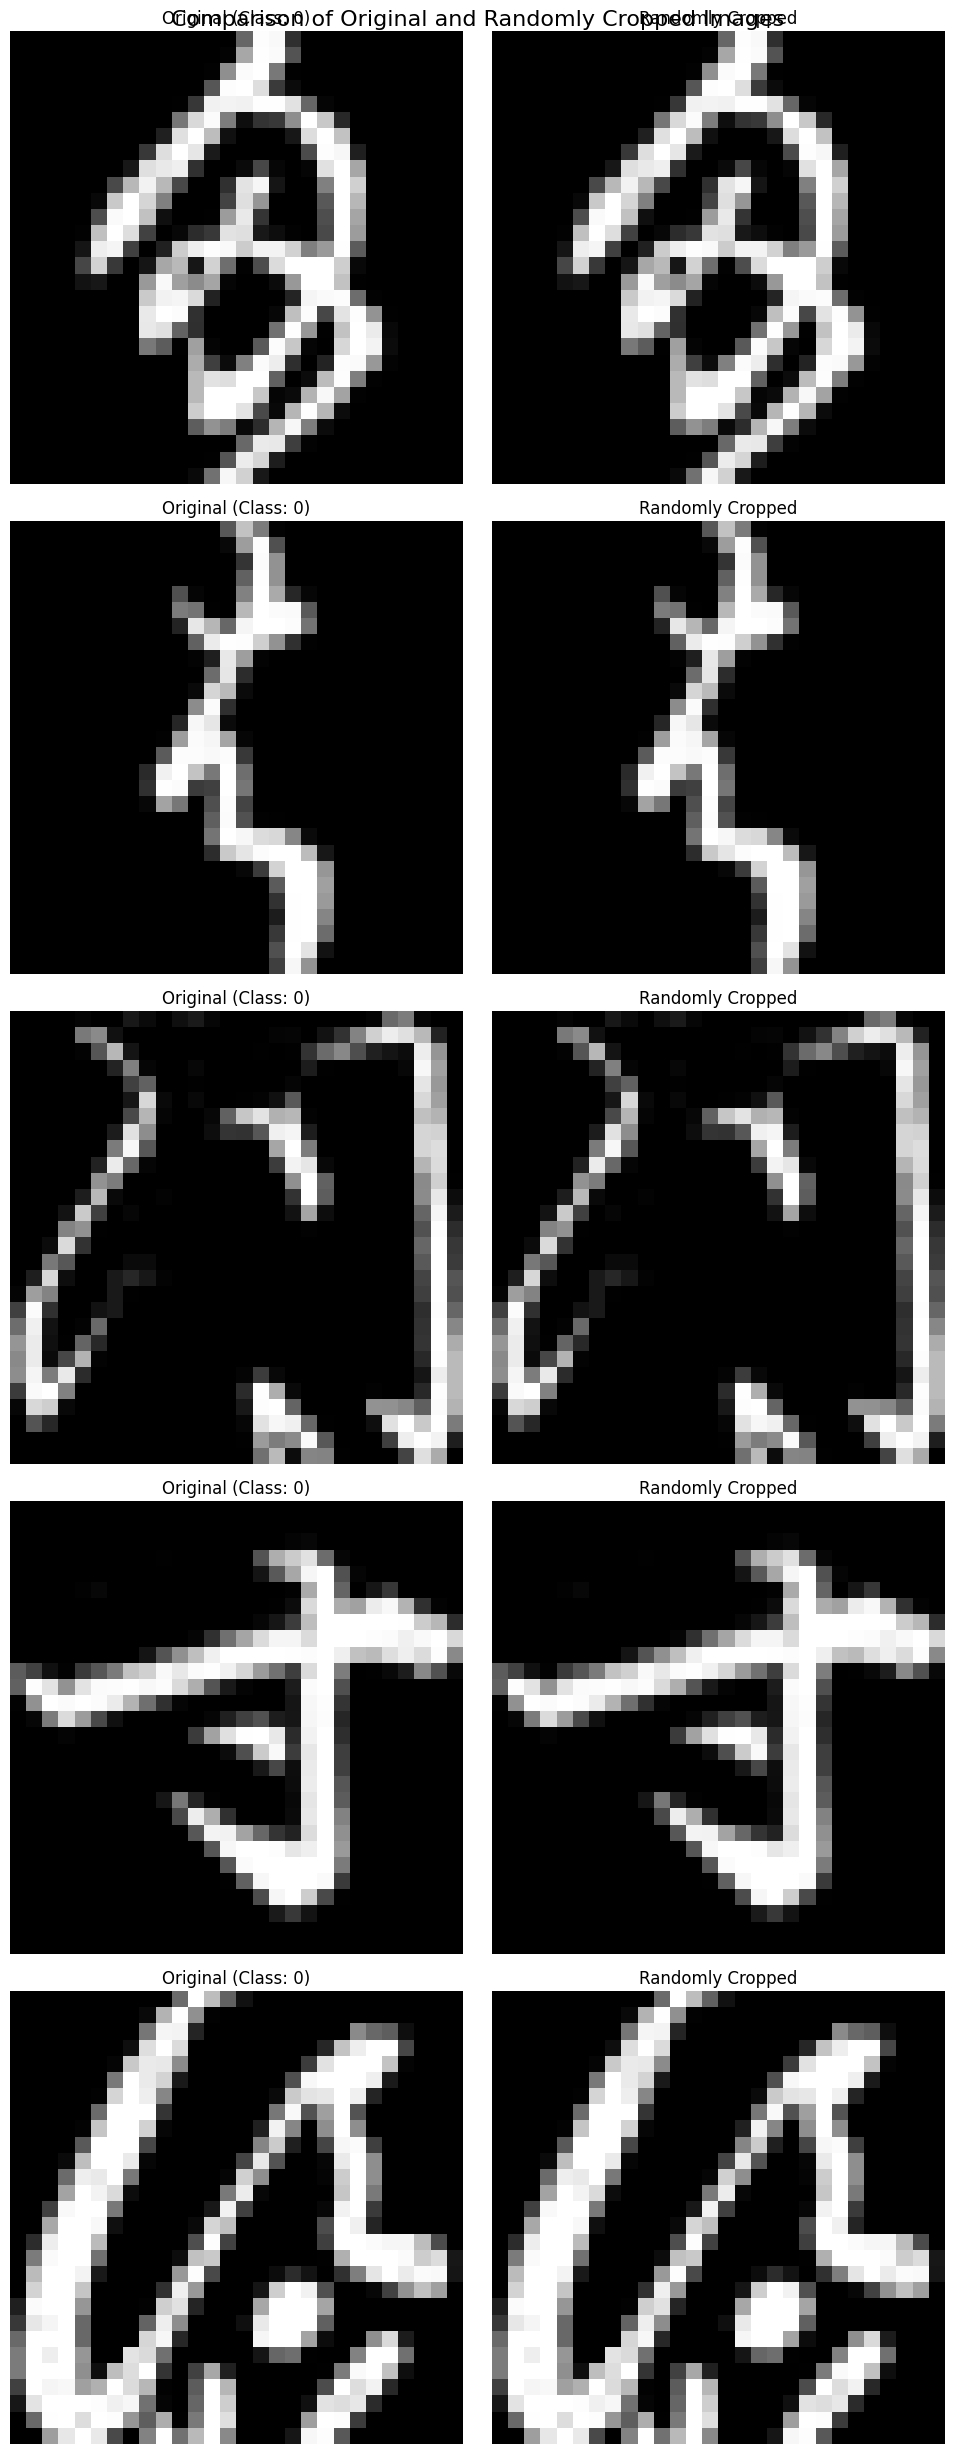

In [12]:
# Function to apply random cropping
def apply_random_crop(image):
    return tf.image.random_crop(image, size=[28, 28, 1]).numpy()

# Select a few random samples
num_samples = 5
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)

# Create a figure to display the samples
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
fig.suptitle("Comparison of Original and Randomly Cropped Images", fontsize=16)

for i, idx in enumerate(sample_indices):
    original_image = x_test[idx]
    cropped_image = apply_random_crop(original_image)
    
    axes[i, 0].imshow(original_image.squeeze(), cmap='gray')
    axes[i, 0].set_title(f"Original (Class: {np.argmax(y_test[idx])})")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(cropped_image.squeeze(), cmap='gray')
    axes[i, 1].set_title("Randomly Cropped")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()